# EDA and Cleaning of Diabetics Data

- First Step to load data frame
- Second Step to create Dictionary to converge into one dataset. This will make reading the inital dataset a little easier. 

In [1]:
# Libraries to load
import pandas as pd
import numpy as np 
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import zscore 

# data visualization packages 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
pd.set_option('max_columns', None)
import pandas_profiling

# SMOTE package to address imbalanced classes 
from imblearn.over_sampling import SMOTE 

from warnings import filterwarnings
filterwarnings('ignore')
np.random.seed(123)

In [2]:
# Load DF
df = pd.read_csv('./data/diabetic_data.csv', na_values='?')

In [3]:
# Shape of dataframe
df.shape

(101766, 50)

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [5]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

# Cleaning - Missingness

<AxesSubplot:>

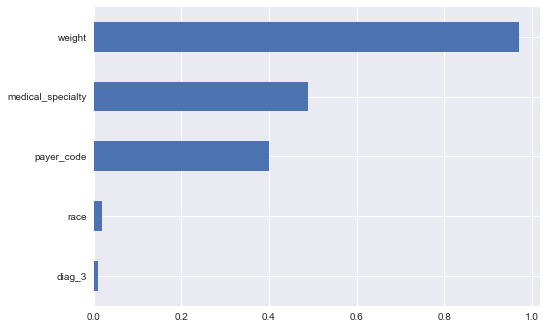

In [6]:
# Compute missingness 
missing = round((df.isna().sum()/len(df)),2).sort_values(ascending = True)
missing = missing[missing > 0]
missing.plot(kind='barh')

In [7]:
# Missing values table 
missing_table = pd.DataFrame(data=missing)
missing_table

0
diag_3             0.01
race               0.02
payer_code         0.40
medical_specialty  0.49
weight             0.97

In [8]:
# Create target column
#Set all values <30 to YES (Readmission), else all other values to NO
df.readmitted = df.readmitted.apply(lambda x: 'Yes' if x in ['<30'] else 'No')

In [9]:
# Drop columns for missingness
df = df.drop(columns="weight")
df = df.drop(columns="payer_code")
df = df.drop(columns="medical_specialty")

In [10]:
# Dealing with Missingness
df = df.replace("?",np.NaN)
df.race = df.race.replace(np.NaN,"unknown")
df = df.replace(np.NaN, "missing")

In [11]:
df.isna().sum().sum()

0

# Cleaning - Delete Multiple Encounters

In [12]:
# Drop duplicate values for patient number. Keep first entry to show if patient was readmitted or not. 
df = df.drop_duplicates('patient_nbr', keep = 'first')
df = df.drop(columns="encounter_id")
df = df.drop(columns="patient_nbr")
df.shape

(71518, 45)

In [13]:
df

race  gender      age  admission_type_id  \
0             Caucasian  Female   [0-10)                  6   
1             Caucasian  Female  [10-20)                  1   
2       AfricanAmerican  Female  [20-30)                  1   
3             Caucasian    Male  [30-40)                  1   
4             Caucasian    Male  [40-50)                  1   
...                 ...     ...      ...                ...   
101754        Caucasian  Female  [70-80)                  1   
101755            Other  Female  [40-50)                  1   
101756            Other  Female  [60-70)                  1   
101758        Caucasian  Female  [80-90)                  1   
101765        Caucasian    Male  [70-80)                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
0                             25                    1                 1   
1                              1                    7                 3   
2                              1                    7                 2   
3                              1                    7                 2   
4                              1                    7                 1   
...                          ...                  ...               ...   
101754                         1                    7                 9   
101755                         1                    7                14   
101756                         1                    7                 2   
101758                         1                    7                 5   
101765                         1                    7                 6   

        num_lab_procedures  num_procedures  num_medications  \
0                       41               0                1   
1                       59               0               18   
2                       11               5               13   
3                       44               1               16   
4                       51               0                8   
...                    ...             ...              ...   
101754                  50               2               33   
101755                  73               6               26   
101756                  46               6               17   
101758                  76               1               22   
101765                  13               3                3   

        number_outpatient  number_emergency  number_inpatient  diag_1  \
0                       0                 0                 0  250.83   
1                       0                 0                 0     276   
2                       2                 0                 1     648   
3                       0                 0                 0       8   
4                       0                 0                 0     197   
...                   ...               ...               ...     ...   
101754                  0                 0                 0     574   
101755                  0                 1                 0     592   
101756                  1                 1                 1     996   
101758                  0                 1                 0     292   
101765                  0                 0                 0     530   

         diag_2   diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
0       missing  missing                 1          None      None        No   
1        250.01      255                 9          None      None        No   
2           250      V27                 6          None      None        No   
3        250.43      403                 7          None      None        No   
4           157      250                 5          None      None        No   
...         ...      ...               ...           ...       ...       ...   
101754      574   250.02                 9          None        >7        No   
101755      599      518                 9          None        >8        No   
101756 

# Cleaning - Feature Simplification

In [14]:
# Create a function to group diagnostic codes by range as well as separating diabetes specifically

def diag_grouper(series):
    
    '''takes input as df.col and outputs diagnostic code groupings'''
    
    def no_str(x):
        
        '''takes input as an element of a series and pulls code for diabetes specific disease and E/V categories'''
        
        if '250' in x: return '9999'
        elif 'E' in x: return '123456'
        elif 'V' in x: return '123456'
        elif x == 'missing': return '-654321'
        else: return x
    
    series = series.apply(no_str)
    
    series = series.astype(float)
    
    def num_categ(x):
        
        '''takes input as an element of a series and saves each range as a numerical placeholder'''
        
        if 1 <= x <= 139: return 10000
        elif 140 <= x <= 239: return 10001
        elif 240 <= x <= 279: return 10002
        elif 280 <= x <= 289: return 10003
        elif 290 <= x <= 319: return 10004
        elif 320 <= x <= 389: return 10005
        elif 390 <= x <= 459: return 10006
        elif 460 <= x <= 519: return 10007
        elif 520 <= x <= 579: return 10008
        elif 580 <= x <= 629: return 10009
        elif 630 <= x <= 679: return 10010
        elif 680 <= x <= 709: return 10011
        elif 710 <= x <= 739: return 10012
        elif 740 <= x <= 759: return 10013
        elif 760 <= x <= 779: return 10014
        elif 780 <= x <= 799: return 10015
        elif 800 <= x <= 999: return 10016
        else: return x
        
    series = series.apply(num_categ)
    
    def text_convert(x):
        
        '''takes input as an element of a series and converts each placeholder to string format'''
        
        if x == 10000: return "Infectious and Parasitic Disease"
        elif x == 10001: return "Neoplasms"
        elif x == 10002: return "Endocrine/Metabolic/Immunity Disorder"
        elif x == 10003: return "Blood/Blood Forming Organ Disease"
        elif x == 10004: return "Mental Disorder"
        elif x == 10005: return "Nervous System/Sense Organ Disease"
        elif x == 10006: return "Circulatory Disease"
        elif x == 10007: return "Respiratory Disease"
        elif x == 10008: return "Digestive Disease"
        elif x == 10009: return "Genitourinary Disease"
        elif x == 10010: return "Complications of Pregnancy/Childbirth/Puerperium"
        elif x == 10011: return "Skin Disease"
        elif x == 10012: return "Musculoskeletal/Connective Tissue Disease"
        elif x == 10013: return "Congenital Anomalies"
        elif x == 10014: return "Conditions of Perinatal Origin"
        elif x == 10015: return "Symptoms/Signs/Ill-Defined Conditions"
        elif x == 10016: return "Injury and Poisoning"
        elif x == 9999: return "Diabetes"
        elif x == 123456: return "External Injury/Supplemental"
        elif x == -654321: return "Missing"
    
    return series.apply(text_convert)

In [15]:
# Apply diag_grouper to the data frame
df.diag_1 = diag_grouper(df.diag_1)
df.diag_2 = diag_grouper(df.diag_2)
df.diag_3 = diag_grouper(df.diag_3)

# Perform an 80/20 Split for Hold Out Data

In [16]:
# Perform and 80/20 split of the data
train, test = train_test_split(df, test_size=0.2)

# Plots and Deeper EDA (Training Data Only)

In [17]:
#train.profile_report() - caution greatly increases file size

<AxesSubplot:>

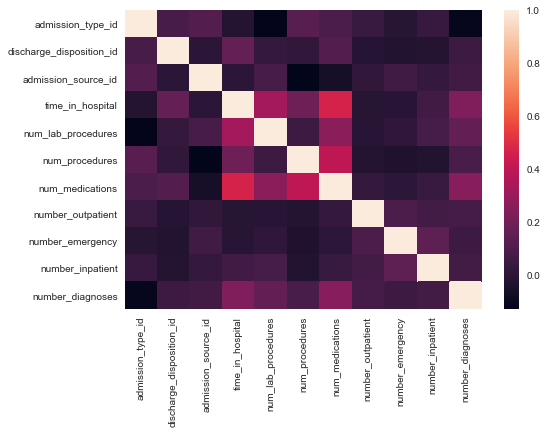

In [18]:
# Looking at correlation - keep an eye out for time_in_hospital vs num_medications
corr = train.corr()
sns.heatmap(corr)

## Write CSV's 

In [19]:
#Main DF
df.to_csv(r'./data.cleaned_df.csv', index = True)

In [20]:
#Test DF
test.to_csv(r'./test_df.csv', index = True)

In [21]:
#Train DF
train.to_csv(r'./train_df.csv', index = True)

# Plots

(array([0, 1, 2, 3]),
 [Text(0, 0, '>7'), Text(0, 1, 'Norm'), Text(0, 2, '>8'), Text(0, 3, 'None')])

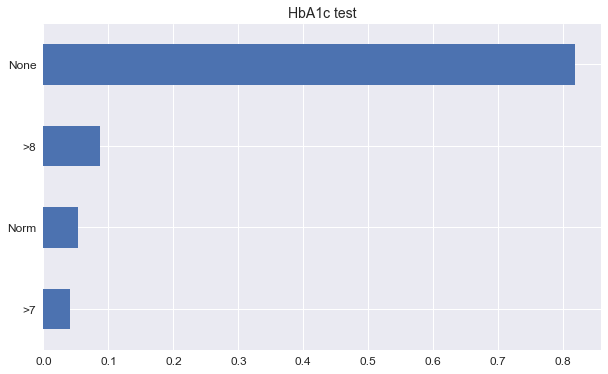

In [22]:
# HbA1c plot
plt.figure(figsize=(10,6))
a1cr_plot = train.A1Cresult.value_counts().sort_values().apply(lambda x: x/train.race.count()).plot(kind='barh')
plt.title('HbA1c test',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1]), [Text(0, 0, 'Ch'), Text(0, 1, 'No')])

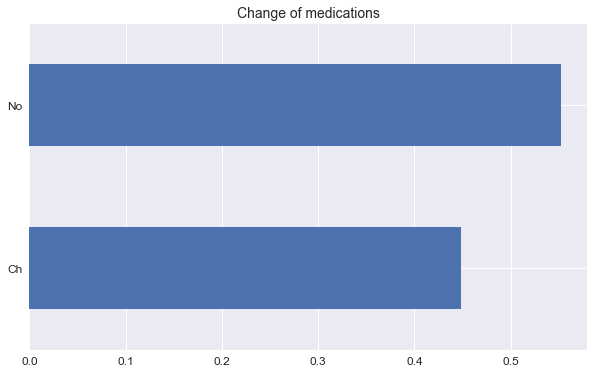

In [23]:
# Med change plot
plt.figure(figsize=(10,6))
change_plot = train.change.value_counts().sort_values().apply(lambda x: x/train.race.count()).plot(kind='barh')
plt.title('Change of medications',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1]), [Text(0, 0, 'Yes'), Text(0, 1, 'No')])

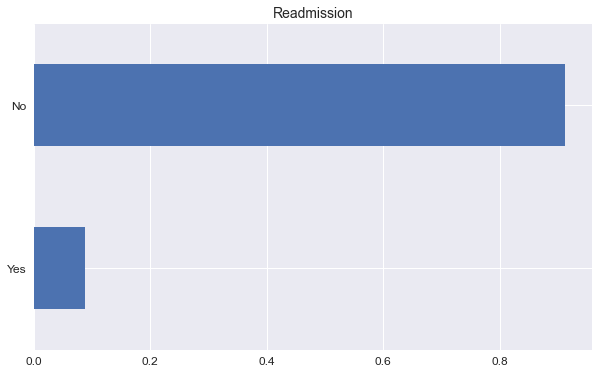

In [24]:
# Readmission plot
plt.figure(figsize=(10,6))
readmission_plot = train.readmitted.value_counts().sort_values().apply(lambda x: x/train.race.count()).plot(kind='barh')
plt.title('Readmission',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1, 2]),
 [Text(0, 0, 'Unknown/Invalid'), Text(0, 1, 'Male'), Text(0, 2, 'Female')])

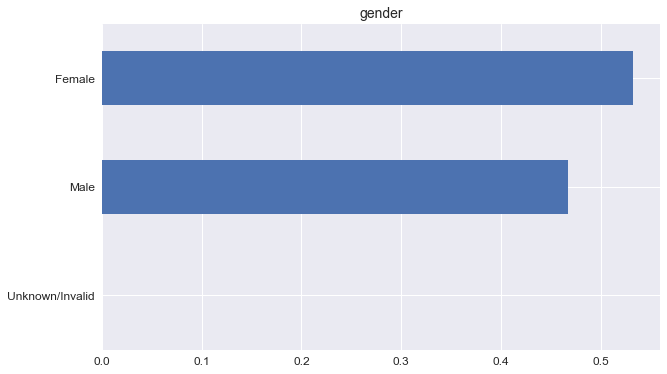

In [25]:
# Gender plot
plt.figure(figsize=(10,6))
gender_plot = train.gender.value_counts().sort_values().apply(lambda x: x/train.race.count()).plot(kind='barh')
plt.title('gender',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '[0-10)'),
  Text(0, 1, '[10-20)'),
  Text(0, 2, '[20-30)'),
  Text(0, 3, '[90-100)'),
  Text(0, 4, '[30-40)'),
  Text(0, 5, '[40-50)'),
  Text(0, 6, '[80-90)'),
  Text(0, 7, '[50-60)'),
  Text(0, 8, '[60-70)'),
  Text(0, 9, '[70-80)')])

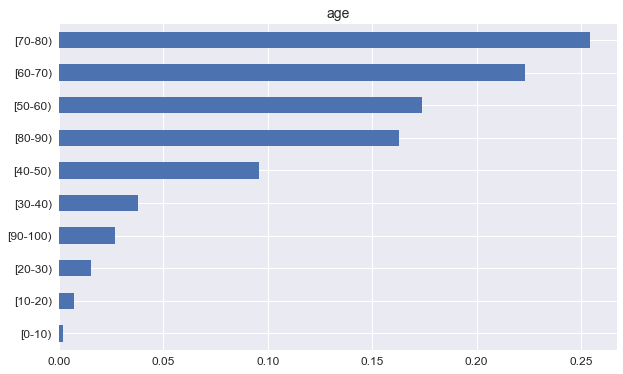

In [26]:
# age plot
plt.figure(figsize=(10,6))
age_plot = train.age.value_counts().sort_values().apply(lambda x: x/train.race.count()).plot(kind='barh')
plt.title('age',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Asian'),
  Text(0, 1, 'Other'),
  Text(0, 2, 'Hispanic'),
  Text(0, 3, 'unknown'),
  Text(0, 4, 'AfricanAmerican'),
  Text(0, 5, 'Caucasian')])

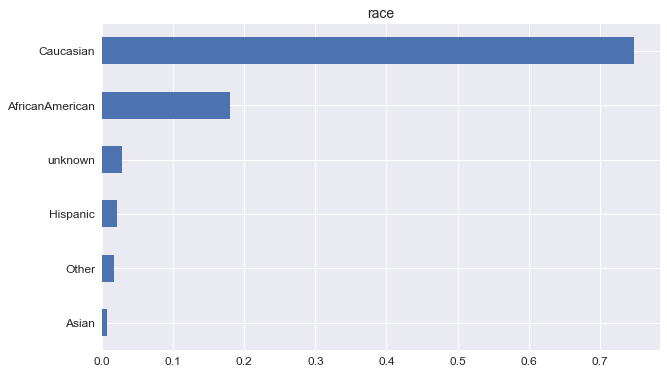

In [27]:
# Race plot
plt.figure(figsize=(10,6))
race_plot = train.race.value_counts().sort_values().apply(lambda x: x/train.race.count()).plot(kind='barh')
plt.title('race',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [28]:
train['max_glu_serum'].replace('>300','>200',inplace=True)
train['A1Cresult'].replace('>8','>7',inplace=True)

In [29]:
#Readmission Table 1: Max Glucouse Serum
train[['max_glu_serum','readmitted', 'race']].groupby(['max_glu_serum','readmitted']).count()

race
max_glu_serum readmitted       
>200          No           1242
              Yes           151
None          No          49714
              Yes          4727
Norm          No           1254
              Yes           126

In [30]:
#Percentage
train[['max_glu_serum','readmitted', 'race']].groupby(['max_glu_serum','readmitted']).count().apply(lambda x: x/train.race.count())

race
max_glu_serum readmitted          
>200          No          0.021708
              Yes         0.002639
None          No          0.868913
              Yes         0.082620
Norm          No          0.021918
              Yes         0.002202

## A1c 

In [31]:
#Readmission Table 2: A1C Result 
train[['A1Cresult','readmitted', 'race']].groupby(['A1Cresult','readmitted']).count()

race
A1Cresult readmitted       
>7        No           6744
          Yes           602
None      No          42649
          Yes          4148
Norm      No           2817
          Yes           254

In [32]:
#Percentage 
train[['A1Cresult','readmitted', 'race']].groupby(['A1Cresult','readmitted']).count().apply(lambda x: x/train.race.count())

race
A1Cresult readmitted          
>7        No          0.117873
          Yes         0.010522
None      No          0.745429
          Yes         0.072500
Norm      No          0.049236
          Yes         0.004439

## Gender

In [33]:
#Readmission Table 3: Gender
train[['gender','readmitted', 'race']].groupby(['gender','readmitted']).count()

race
gender          readmitted       
Female          No          27771
                Yes          2696
Male            No          24436
                Yes          2308
Unknown/Invalid No              3

In [34]:
#Percentage 
train[['gender','readmitted', 'race']].groupby(['gender','readmitted']).count().apply(lambda x: x/train.race.count())

race
gender          readmitted          
Female          No          0.485388
                Yes         0.047121
Male            No          0.427098
                Yes         0.040340
Unknown/Invalid No          0.000052

## Age

In [35]:
#Readmission Table 4: Age
train[['age','readmitted', 'race']].groupby(['age','readmitted']).count()

race
age      readmitted       
[0-10)   No            119
         Yes             3
[10-20)  No            408
         Yes            20
[20-30)  No            816
         Yes            70
[30-40)  No           2016
         Yes           152
[40-50)  No           5097
         Yes           400
[50-60)  No           9231
         Yes           705
[60-70)  No          11640
         Yes          1133
[70-80)  No          13121
         Yes          1431
[80-90)  No           8357
         Yes           961
[90-100) No           1405
         Yes           129

In [36]:
#Percentage
train[['age','readmitted', 'race']].groupby(['age','readmitted']).count().apply(lambda x: x/train.race.count())

race
age      readmitted          
[0-10)   No          0.002080
         Yes         0.000052
[10-20)  No          0.007131
         Yes         0.000350
[20-30)  No          0.014262
         Yes         0.001223
[30-40)  No          0.035236
         Yes         0.002657
[40-50)  No          0.089087
         Yes         0.006991
[50-60)  No          0.161342
         Yes         0.012322
[60-70)  No          0.203447
         Yes         0.019803
[70-80)  No          0.229332
         Yes         0.025011
[80-90)  No          0.146066
         Yes         0.016797
[90-100) No          0.024557
         Yes         0.002255

### Race

In [37]:
#Readmission Table 5: Race
train[['race','readmitted', 'gender']].groupby(['race','readmitted']).count()

gender
race            readmitted        
AfricanAmerican No            9454
                Yes            866
Asian           No             364
                Yes             32
Caucasian       No           38935
                Yes           3837
Hispanic        No            1115
                Yes             94
Other           No             886
                Yes             62
unknown         No            1456
                Yes            113

In [38]:
#Percentage
train[['race','readmitted', 'gender']].groupby(['race','readmitted']).count().apply(lambda x: x/train.gender.count())

gender
race            readmitted          
AfricanAmerican No          0.165239
                Yes         0.015136
Asian           No          0.006362
                Yes         0.000559
Caucasian       No          0.680515
                Yes         0.067064
Hispanic        No          0.019488
                Yes         0.001643
Other           No          0.015486
                Yes         0.001084
unknown         No          0.025448
                Yes         0.001975

# Outliers

In [39]:
# 3 rows have outliers
numeric = train.dtypes[train.dtypes != "object"].index
zscore_ = np.abs(zscore(train[numeric]))

row, col = np.where(zscore_>4)
dfz = pd.DataFrame({'row': row, 'col': col})
rows = dfz.groupby(['row']).count()
outliers = rows[rows.col>2].index
outliers

Int64Index([30097, 42715, 53792], dtype='int64', name='row')